# Carbon Dioxide Removal Modeling Experiments
This workbook contains CDR Experiments in climate modeling simulation software run in pymagicc and subsequently MAGICC.

Github Project Code: https://github.com/hsbay/cdrmex, CC-BY 4.0 2021 @safiume

CDRMEx Project: https://opennanocarbon.atlassian.net/wiki/spaces/REF/pages/575963137/Method+to+Determine+A+CDR+Target @safiume

Pymagicc, https://pymagicc.readthedocs.io, Version 2.0: https://doi.org/10.5281/zenodo.1111815, AGPL-3.0
R. Gieseke, S. N. Willner and M. Mengel, (2018). Pymagicc: A Python wrapper for the simple climate model MAGICC. Journal of Open Source Software, 3(22), 516, https://doi.org/10.21105/joss.00516

Magicc6 provided by pymagicc:
MAGICC6, http://www.magicc.org/download6, CC-BY-NC-SA-4.0
The software model is explained in 'Emulating coupled atmosphere-ocean and carbon cycle models with a simpler model, MAGICC6 – Part 1: Model description and calibration', M. Meinshausen, S. C. B. Raper and T. M. L. Wigley, (2011), Atmospheric Chemistry and Physics 11: 1417-1456. https://doi.org/10.5194/acp-11-1417-2011, and 'Emulating atmosphere-ocean and carbon cycle models with a simpler model, MAGICC6 – Part 2': Applications https://doi.org/10.5194/acp-11-1457-2011

## Description
This is the main workbook for Carbon Dioxide Removal Modeling Experiments.
The cells below set up the experiments, run MAGICC and generate graphs and list the experiment results.

This workbook runs python, pymagicc, wine, and MAGICC. 

## Directions
To generate the graphs, run all the cells after installing python, pymagicc, and wine according to http://localhost:8888/README.md or https://github.com/hsbay/cdrmex. Note, pymagicc will install MAGICC for you; the download page is only for reference. This workbook will configure MAGICC for you.

To generate the main graphs, select Kernel|Restart & Run all in Jupyter.

To see all the 21 other invidiual GHGs emissions decline, skip down to 'Show individual gasses for 300 ppm by 2050 scenario' and uncomment that entire section, then select Kernel|Restart & Run all in Jupyter.

#### Dependencies
This file, https://github.com/hsbay/cdrmex/blob/main/utils.py, https://github.com/hsbay/cdrmex/tree/main/SCEN/*, python, pymagicc, wine if not on windows.

#### Start python, load pymagicc and utilities.

In [1]:
# NBVAL_IGNORE_OUTPUT
import sys, re
from os import listdir
from os.path import join, dirname, abspath
from pprint import pprint
import expectexception
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import f90nml

In [2]:
# Disable warning supression if running locally
import warnings
warnings.simplefilter('ignore', category=Warning, lineno=0, append=False)

In [3]:
import pymagicc
from pymagicc import MAGICC6
from pymagicc.io import MAGICCData, read_cfg_file, NoReaderWriterError
from pymagicc.scenarios import ( rcp26, rcp45, zero_emissions )
from scmdata import run_append
from scmdata import ScmRun
import utils                            # import local utilities

# report versions
print(pymagicc.__version__)
print(sys.version)
rcp26.__class__.__bases__

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


2.0.0rc8+19.g7aade1e.dirty
3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


(scmdata.run.ScmRun,)

#### MAGICC Configuration and Workbook tuneables.
The following cells reset the zero $0^{\circ}C$ of warming, MAGICC setables in the *.CFG MAGICC files, and workbook settings like the end of Industrial Fossil Fuels, location of additional user-defined Scenario files, dates to start and stop MAGICC, and reset the x-axis and timeline for the graphs. 

##### Re-adjust Baseline Mean
The baseline for 0°C will be recalculated based on the mean
temperature for 1720-1800, which roughly equals temp at 1786.
Baseline temperature global mean 1720 to 1800:
https://doi.org/10.1175/BAMS-D-16-0007.1

In [4]:
zero_out_temp_start = 1720+1
zero_out_temp_end = 1800+1

### MAGICC tunables section, and major program tunables

Chose a magic['startyear'] of any year before the start of Anthro
emissions, i.e., 1765 for MAGICC6.

These settings will tune the final temperature response output. These settings
have minimal to no effect on radiative forcing, as such the RF region information
doesn't correlate to final temperature evolution. See https://github.com/hsbay/cdrmex/issues/22

In [5]:
pd.set_option('precision', 4)
#pd.set_eng_float_format(accuracy=2)

## List of experiments in declines
declines = ['emax', 'lmax', 'emin', 'lmin']
SCEN_DIR = 'SCEN'
MAGICC6_DIR = join('..', 'CDRRUN')

# 100% Elimination of FF industries Year Start
stFF = 2078
# Emissions End
effend = 2100

## Start of MAGICC settings
magcfg = {'startyear' : 1751,                          # Include 1750 for NE calibration for MAGICC 
          'endyear' : 2650,                            # 2662 Maximum end year
          'core_climatesensitivity' : 3.3,            # [2.4-3.5] best linefits for 2015-2020 Current Temps
          'core_feedback_qsensitivity': 0,             # default (per magicc6.8)
          'core_verticaldiffusivity' : 2.3,            # default (per magicc6.8)
          'core_verticaldiffusivity_min' : .1,         # (1.000000e-001 per mag6.8)
          'core_verticaldiff_top_dkdt' : 0,            # default (per magicc6.8)
          'core_adjust_sst2ocnatm' : 1.25,             # default (per magicc6.8)
          'core_rlo' : 1.3,                            # (1.3 per magicc6.8)
          'core_heatxchange_landocean' : 1,            # (1 per magicc6.8)
          'core_amplify_ocn2land_heatxchng' : 1,       # default (per magicc6.8)
          'core_heatxchange_northsouth' : 1,           # (1 per magicc6.8, 0.3115475 pymagicc)
          'co2_preindco2conc' : 276.744,               # (278 magicc6.8 default)
          'co2_preindco2conc_apply' : 1,
          'co2_feedbackfactor_gpp' : .015,             # (0.015 per magicc6.8)
          #'co2_tempfeedback_yrstart' : 1930,
          #'co2_fertilization_yrstart' : 1930,
          'co2_switchfromconc2emis_year' : 2005,
          'rf_total_constantafteryr' : 5000,           # Affects overall warming & ppm, via N2O
          'rf_tropoz_constantafteryr' : 5000,
          'rf_stratoz_constantafteryr' : 5000,
          'rf_mhalo_constantafteryr' : 5000,
          'rf_fgas_constantafteryr' : 5000,
          'rf_landuse_constantafteryr' : 5000,         # Affects warming by lowing CO2 ppm into land-sink
          'n2o_switchfromconc2emis_year' : 2005,
          'fgas_switchfromconc2emis_year' : 2005,
          'mhalo_switch_conc2emis_yr' : 2008,
          'out_forcing' : 1,
          'out_emissions' : 1,
          'out_concentrations' : 1,
          'out_temperature' : 1,
          'out_aogcmtuning' :  1,
          'out_ccycletuning' :  1,
          'out_parameters' : 1,
          'out_carboncycle' : 1,
          'out_warnings' : 1,
          'out_misc': 1,
         }
### End MAGICC Settings

##### MAGICC6 Forcing Issues
Indirect Aerosols persist positively after FF is stopped. Mineral dust forcing causes an increase in Indirect Aerosols well past 2500. Need to find the setting to halt $N_2O$ emissions after restoring to pre-industry levels. F gasses and Halocarbons force the odd spike even though those are set to decrease by Montreal Protocol/Kigali Amendment. A few continue to have positive forcing past their emission lifetime.

Definitions in:
    
    MAGCFG_DEFAULTALL_69.CFG:  FILE_MHALO_EMIS = 'WMO2006_ODS_A1Baseline.prn',
    MAGCFG_USER.CFG:    file_mhalo_conc = 'RCPODS_WMO2006_MixingRatios_A1.prn'
    MAGCFG_USER.CFG:    file_mhalo_emis = 'RCPODS_WMO2006_Emissions_A1.prn'

have been left to their default, per: 
    Scientific assessment of ozone depletion: 2006. Global ozone research and monitoring project 
    Report No. 50. Geneva, Switzerland, World Meteorological Organization: 572, Chapter 8; 
    & Butler et al. 1999, https://doi.org/10.1038/21586

###### MAGICC Cold-Start and CDR Issue
Cold-starts of a time past pre-industry via rf_preind_referenceyr = 1750
effects $CO_2$ removal possibly with extreme hysteresis and likely out 
of deterministic bounds. Positive emissions seem unaffected.

###### MAGICC Date Feature
The minimum temperature pre-removal was during 1817. This year corresponds to the global cooling from the 'Year of Poverty or No Summer': 1816. This global cooling was due to volcanic activity during the previous years. Since the date is one year out, and MAGICC's yearly points for January 1, the model output reflects the previous year. I've adjusted the GCB Harmonization to one year backward. The year 2021 in the data frames reflects the records in the prior year. I've also tuned MAGICC internals to speed up the air/sea interaction such that temperature is closely correlated to the 2020 year (2021 in MAGICC.)

In [6]:
# Reassign startyear to include the year 1720.
graphstart = magcfg['startyear']
if magcfg['startyear'] > zero_out_temp_start:
    magcfg['startyear'] = zero_out_temp_start

In [7]:
# load experiments scen file data
for n, name in enumerate (declines):
    declinefile = join(SCEN_DIR, 'ONC' + name + '.SCEN')
    declines[n] = MAGICCData(declinefile,
                             columns={'model': ['CDRex'], 'scenario': [name]})
# Copy lmin data into new experiment
CCCx2050 = declines[3]

##### IMAGE SSP1 1.9 
IMAGE-SSP1-1.9 was imported manually from 
'IMAGE 3.0.1','SSP1-19','World','Diagnostics|MAGICC6|Harmonized Input|*

© IAMC 1.5°C Scenario Explorer hosted by IIASA https://data.ene.iiasa.ac.at/iamc-1.5c-explorer

In [8]:
# Reshape Image 3.01 SSP1 1.9 to match MAGICC6 format
# Convert to GtC, N, S

ys = np.arange(2010,2110,10)
ssp119 = pd.read_csv(join(SCEN_DIR, 'ssp119.csv'))
svars = ssp119['variable']
sunits = ssp119['unit']
sdata = ssp119.iloc[0:23,5:]
img119 = ScmRun(data=sdata.T,
                index=ys, 
                columns={
                    'climate_model': 'unspecified',
                    'model': 'IMAGE',
                    'region': 'World',
                    'scenario' : 'SSP-119',
                    'todo':'SET',
                    'unit' : sunits,
                    'variable' : svars})
img119df = img119.timeseries()
img119df = img119df.rename({'Emissions|CO2|AFOLU':'Emissions|CO2|MAGICC AFOLU'}, axis='index')
img119df = img119df.rename({'Mt CO2/yr':'Gt C/yr'}, axis='index')
img119df.iloc[5] = img119df.iloc[5] / 3664
img119df.iloc[6] = img119df.iloc[6] / 3664
img119df = img119df.rename({'Emissions|HFC245ca':'Emissions|HFC245fa'}, axis='index')
img119df = img119df.rename({'kt N2O/yr':'Mt N2ON/ yr'}, axis='index')
img119df.iloc[15] = img119df.iloc[15] / 1400.7
img119df = img119df.rename({'Mt NH3/yr':'Mt N/ yr'}, axis='index')
img119df = img119df.rename({'Mt NO2/yr':'Mt N/ yr'}, axis='index')
img119df.iloc[17] = img119df.iloc[17] / 3.286
img119df = img119df.rename({'Mt SO2/yr':'Mt S/ yr'}, axis='index')
img119df.iloc[21] = img119df.iloc[21] / 1.998
pd.set_option('precision', 4)
img119 = MAGICCData(img119df.copy())

#### Copy the linear minimum experiment to populate our new experiment 300 ppm X 2050.
Linear Minimum experiment takes all the gasses other than $CO_2$ and linearly declines them to zero by 2100.

In [9]:
# Setup 300ppm at 2050 experiment from LinearMin Experiment
CCC_df = CCCx2050.timeseries()
CCC_df = CCC_df.rename(index={'lmin':'CCCx2050'})

#### Calculate carbon to remove pre 2050 and post 2050, such that at 2050, $CO_2$ ppm is 300.

In [10]:
# Calculate how much carbon to remove to achieve 300 ppm at 2050

CRsyr = 2030
Bkyr = 2050

# Anthropogenic Fossil Fuel Emissions 
# CO₂ gas in GtC
AnthroC = 480.5300944182998819

# Anthropogenic Land-use Change Emissions
# CO₂ gas in GtC
LuC = 207.2620913067000524       # MAGICC Cumulative LUC

# to 300 ppm
AC_2050 =  203        # 
LuC_2050 = 54.58      #

# Remove imbalance and LUC overage from AnthroC
# GCB 2020, and rounding errors. And post
# 2100-2500 land sink productivity?

skew = 0

In [11]:
# gas defination helpers
ems_ff = 'Emissions|CO2|MAGICC Fossil and Industrial'
ems_luc = 'Emissions|CO2|MAGICC AFOLU'
methane = 'Emissions|CH4'
emsf = ('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr', ems_ff)
emsluc = ('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr', ems_luc)

In [12]:
# Zero anthro CO₂ data past 2010 
CCC_df.loc[emsf, datetime(2010,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_df.loc[emsluc, datetime(2010,1,1,0) : datetime(2150,1,1,0)] = 0

#### Prepare GhGs data for Carbon Removal. CDR starts at 2022
This cell initializes the settings needed to configure the Kigali Amendment to the Montreal Protocol controlled gasses, Fossil Fuel and Land-use $CO_2$, and additional Methane, CO, Nx, Sx, OC, BC, Fgasses, other Halo, and ammonia. $CO_2$ are harmonized with the Global Carbon Budget 2020 https://doi.org/10.18160/GCP-2020 through 2020, and then decrease to hit zero in 2023. All gas species except ammonia and $CO_2$ linearly decline till reaching zero at the end of FF. The Montreal Protocol controlled gasses decline per the Kigali Amendment. $CO_2$ goes negative and remains a high negative removal to remove all accumulated carbon in the atmosphere and oceans since 1750. Ammonia emissions average out to a slight rise at 2100. 

In [13]:
ki_mo_ghgs_F = [ 'HFC134a', 'HFC245fa', 'HFC227ea', 'HFC4310', 'HFC32', 'HFC125', 'HFC143a', 'HFC23' ]

#Inc Kigali/MontrealP GhG years
timepts = {
    'kigyr1' : [2019, .998],
    'pkyr' : [(CRsyr - 1), 1],
    'kigyr2' : [2024, .95], 
    'kigyr3' : [2025, .65],
    'kigyr4' : [2029, .30],
    'kigyr5' : [2034, .20],
    'sf6eu' : [2030, .30],
    'kigyr6' : [2036, .15],
    'edyr' : [effend, 0.00]
}
timepts.update({ 'CRsyr': [CRsyr, .97 ], 'Bkyr': [Bkyr, 0] })
timepts = pd.DataFrame(timepts,['year','NtZeroPcnt']).T
timepts = timepts.sort_values(by='year')

#Zero emissions for non CO2 gasses
ghg0dates = [stFF, effend]

# harmonize to GCB(2020) FF+luc Ghg
# https://doi.org/10.18160/GCP-2020, 9.4 est 2021
# MAGICC:[2010-2022] => GCB [2009-2023]
FF=[ 8.59, 9.04, 9.34, 9.49, 9.55, 9.62, 9.61, 9.61, 9.74, 9.94, 9.95, 9.3, 9.4, 6, 0]
# 2005, 2010...2022 => GCB 2004, [2009-2023]
luc=[1.51, 1.60, 1.46, 1.38, 1.49, 1.53, 1.65, 1.70, 1.56, 1.52, 1.55, 1.80, 1.6, 1]

#### Calculate the new values partially from the older Linear Minimum experiment.
The Linear Minimum experiment has both the table structure and basic linear declines for all gas species. The code builds Linear Minimum, and then this next block generates the Kigali controlled gas values, Methane, $CO_2$, and truncates the declines to 0 at the end of fossil fuels defined in stFF.

In [14]:
def dtspn(emm,dates,vals,df):
    if type(emm) == str:
        ndf = df.xs(emm, level = 'variable', drop_level = False)
    else :
        ndf = df.loc[:,:,:,:,:,:,emm]
    row = ndf.index.values
    ndf.at[row, datetime(dates[0],1,1) : datetime(dates[1],1,1)] = vals
    df.loc[ndf.index.values] = ndf 
    return df

def kigali(ki_ghgs,df):
    kgfs = []
    for kgs in ki_ghgs:
        kgs = ('Emissions|') + kgs
        kgfs.append(kgs)
    ndf = df.loc[:,:,:,:,:,:,kgfs]
    row = ndf.index.values
    mxyr = int(timepts.loc['pkyr'][0])    
    for i, tmpt in enumerate(timepts['year']):
        if tmpt < (timepts['year'].max()):
            tmpt = int(tmpt)
            nxtyr = int(timepts.iloc[[i+1],0])
            rate = timepts.iloc[[i],1].values
            rates = ndf.loc[:, datetime(mxyr,1,1,0)] * rate
            srws = ndf.loc[row, datetime(tmpt,1,1,0) : datetime(nxtyr,1,1,0)]
            srws.apply(lambda x: x * rates.values)
    df.loc[row] = ndf
    return df

def decline(ems, dates, xrate, df):
    ndf = df.xs(ems, level = 'variable', drop_level = False)
    row = ndf.index.values
    slc = ndf.loc[row, datetime(dates[0],1,1):datetime(dates[1],1,1)]
    slc.apply(lambda x: x * xrate)
    df.loc[ndf.index.values] = ndf
    return df

In [15]:
df = CCC_df.copy()
dates = [2010, 2024]
df = dtspn( ems_ff, dates, FF, df)
dates = [2005, 2022]
df = dtspn( ems_luc, dates, luc, df)
df = kigali(ki_mo_ghgs_F, df)

In [16]:
xrate = -0.336
dates = [2021, 2049]
df = decline(methane, dates, xrate, df)
dates = [2022, 2028]
ffvals = np.linspace(6,-9.2,(2028-2022+1))
df.loc[emsf,datetime(dates[0],1,1):datetime(dates[1],1,1)] = ffvals
df.loc[emsf,datetime(2029,1,1)] = -9.2
dates = [2022, 2025]
lucval = -2.729
lucvals = np.linspace(0,lucval,(2025-2022+1)) 
df.loc[emsluc,datetime(dates[0],1,1):datetime(dates[1],1,1)] = lucvals
dates = [2026, 2029]
df.loc[emsluc,datetime(dates[0],1,1):datetime(dates[1],1,1)] = lucval
# strip CO₂ FF, Luc, NH3 from index.values
ghg0 = df.index.get_level_values(6)[[2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22]]
val = (0)
df = dtspn( ghg0, ghg0dates, val, df)
CCC_df = df.copy()
#df.loc[:,:datetime(2030,1,1)]

#### Calculate CDR (Negative Emissions) to remove all cumulative anthropogenic emissions since 1750 and end removal at 2100.
This block calculates how much carbon to remove all the accumulated $CO_2$ emissions. It balances the removal before 2050 to reach $CO_2$ 300 ppm at 2050 and then removes the remaining accumulated emissions until 2100.

In [17]:
# remove -FF emissions up to CRsyr = 2030
AnthroC2029 = AnthroC + CCC_df.loc[emsf,datetime(2025,1,1):datetime(CRsyr-1,1,1)].T.sum()
# remove -FF from LUC 2022-2029
LuC2029 = LuC + CCC_df.loc[emsluc,datetime(2023,1,1):datetime(CRsyr-1,1,1)].T.sum()

# calculate to 300 ppm
landsnk_yrly = LuC_2050/((Bkyr) - CRsyr)
landsnc_remainingYr = (LuC2029 - LuC_2050)/50
Peak_to_bk_yr = AC_2050/((Bkyr) - CRsyr)
Remaining_per_yr = (AnthroC2029 - AC_2050 - skew)/50

# Set removal according to forumlas in previous cell
CCC_df.loc[emsluc, datetime(CRsyr,1,1) : datetime(2049,1,1)] = -landsnk_yrly
CCC_df.loc[emsluc, datetime(2050,1,1) : datetime((effend-1),1,1)] = -landsnc_remainingYr
CCC_df.loc[emsf, datetime(CRsyr,1,1) : datetime(2049,1,1)] = -Peak_to_bk_yr
CCC_df.loc[emsf, datetime(2050,1,1) : datetime((effend-1),1,1)] = -Remaining_per_yr

### Diagnostics: Print Cumulative emissions and verify 0 carbon remains after $CO_2$ removal.

In [18]:
#Diags
print('AnthroC is                                      {:.4f}'.format(AnthroC))
print('Anthro Emissions from 2025 plus AnthroC           {:.4f}'.format(
         CCC_df.loc[emsf,datetime(2025,1,1):].T.sum() + AnthroC ))
print('Anthro Emissions plus AnthroC - skew              {:.4f}'.format(       
         CCC_df.loc[emsf,datetime(2030,1,1):].T.sum() + AnthroC2029 ))
print('\n')
print('LandUseChange is                                {:.4f}'.format(LuC))
print('LandUseChange Emissions from 2022              {:.4f}'.format(
        CCC_df.loc[emsluc,datetime(2023,1,1):].T.sum()))
print('LanduseChange Emiss plus LandUseC inventory      {:.4f}'.format(
        CCC_df.loc[emsluc,datetime(2023,1,1):].T.sum() + LuC))
#CCC_df.style #print copy for diags

AnthroC is                                      480.5301
Anthro Emissions from 2025 plus AnthroC           0.0000
Anthro Emissions plus AnthroC - skew              0.0000


LandUseChange is                                207.2621
LandUseChange Emissions from 2022              -207.2621
LanduseChange Emiss plus LandUseC inventory      -0.0000


In [19]:
# Rewrite CCCx2050 from timeseries and wrap in MAGICCData
CCCx2050 = MAGICCData(CCC_df.copy())
#CCCx2050.write(join(SCEN_DIR,'CCCx2050.SCEN'),magicc_version=6)
#CCC_df.to_csv('CCCx2050.csv')

CCC_flat = CCC_df.copy()
CCC_flat.loc[emsf, datetime(2051,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_flat.loc[emsluc, datetime(2051,1,1,0) : datetime(2150,1,1,0)] = 0
CCC_flat = CCC_flat.rename(index={'CCCx2050':'CCCxflat'})
CCCxflat = MAGICCData(CCC_flat.copy())

### Diagnostics: Yearly $CO_2$ Removal Rates

In [20]:
dts =  [ datetime(2019,1,1,0), datetime(2029,1,1,0), datetime(2030,1,1,0), datetime(2051,1,1,0) ]
xsff = CCC_df.xs(('unspecified', 'CDRex', 'World', 'SET'), 
                 level = ('climate_model', 'model', 'region', 'todo'), 
                 drop_level=True).xs(ems_ff, level = 'variable', drop_level=False).loc[:,dts]
xsluc = CCC_df.xs(('unspecified', 'CDRex', 'World', 'SET'), 
                  level = ('climate_model', 'model', 'region', 'todo'), 
                  drop_level=True).xs(ems_luc, level = 'variable', drop_level=False).loc[:,dts]
xsdf = pd.concat([ xsff, xsluc ])
cdrco2 = (xsdf.T * 3.664).T
cdrco2 = cdrco2.rename(index={'Gt C / yr':'Gt $CO_2$/yr'})
pd.concat((xsdf, cdrco2))

time                                                              2019-01-01  \
scenario unit         variable                                                 
CCCx2050 Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial      9.9400   
                      Emissions|CO2|MAGICC AFOLU                      1.5500   
         Gt $CO_2$/yr Emissions|CO2|MAGICC Fossil and Industrial     36.4202   
                      Emissions|CO2|MAGICC AFOLU                      5.6792   

time                                                              2029-01-01  \
scenario unit         variable                                                 
CCCx2050 Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial     -9.2000   
                      Emissions|CO2|MAGICC AFOLU                     -2.7290   
         Gt $CO_2$/yr Emissions|CO2|MAGICC Fossil and Industrial    -33.7088   
                      Emissions|CO2|MAGICC AFOLU                     -9.9991   

time                                                              2030-01-01  \
scenario unit         variable                                                 
CCCx2050 Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial    -10.1500   
                      Emissions|CO2|MAGICC AFOLU                     -2.7290   
         Gt $CO_2$/yr Emissions|CO2|MAGICC Fossil and Industrial    -37.1896   
                      Emissions|CO2|MAGICC AFOLU                     -9.9991   

time                                                              2051-01-01  
scenario unit         variable                                                
CCCx2050 Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial     -4.9346  
                      Emissions|CO2|MAGICC AFOLU                     -2.7262  
         Gt $CO_2$/yr Emissions|CO2|MAGICC Fossil and Industrial    -18.0804  
                      Emissions|CO2|MAGICC AFOLU                     -9.9887

### Diagnostics: Print years around net-zero and net-zero for end of GHGs.
Print three years before and after the end of positive $CO_2$ emissions and a decade before 
the end of all fossil-based industrial GHGs, and two years post.

The end of $CO_2$ emissions happens early mid 2024 in MAGICC years, mid 2023 in calendar years.

The time period around the end of all other GHGs is linked to the end of $N_2O$ emissions 
and presently forces a kickback in heat and temperature response. Moving this number out to
the late 2070s minimizes this kickback. $N_2O$ lifetimes are referenced in 
WMO2006_ODS_A1Baseline.prn. See MAGICC6 Forcing Issues listed above.

In [21]:
# print start End of Fossil Fuels
co2nz = 2025
nzyrs = np.arange(co2nz-5,co2nz+3)
nzyrs = np.append(nzyrs, np.arange(stFF-10,stFF+2))
nzy = ()
for n in nzyrs:
    nzy = np.append(nzy, datetime(n,1,1,0))
nzyrs = nzy
CCC_df.loc[:,nzyrs].style

##### Show the data frame percision.

In [22]:
pd.get_option('precision')

4

In [23]:
# Force sample rcp26 to end CR at 2101
rcp26df = rcp26.timeseries()
rcp26df = rcp26df.rename(columns={datetime(2125,1,1,0,0):datetime(2101,1,1,0,0)})
rcp26df.loc[:, datetime(2101,1,1,0) : datetime(2500,1,1,0)] = 0
rcp26 = MAGICCData(rcp26df.copy())

# Scenarios

The experimental declines are loaded as DataFrames in pyhector. They contain the following emissions:

### Show individual gasses for 300 ppm by 2050 scenario

In [24]:
#categories_to_plot = CCCx2050['variable'].drop_duplicates().tolist()

#for g in CCCx2050.filter(
#    variable=categories_to_plot,
#    year=range(2000, 2101)
#).groupby('variable'):
#    plt.figure(figsize=(12, 7))
#    g.lineplot(hue='region').set_title(g.get_unique_meta('variable', True))

### Fossil fuel emissions for RCP 2.6 scenario and Experimental Declines.

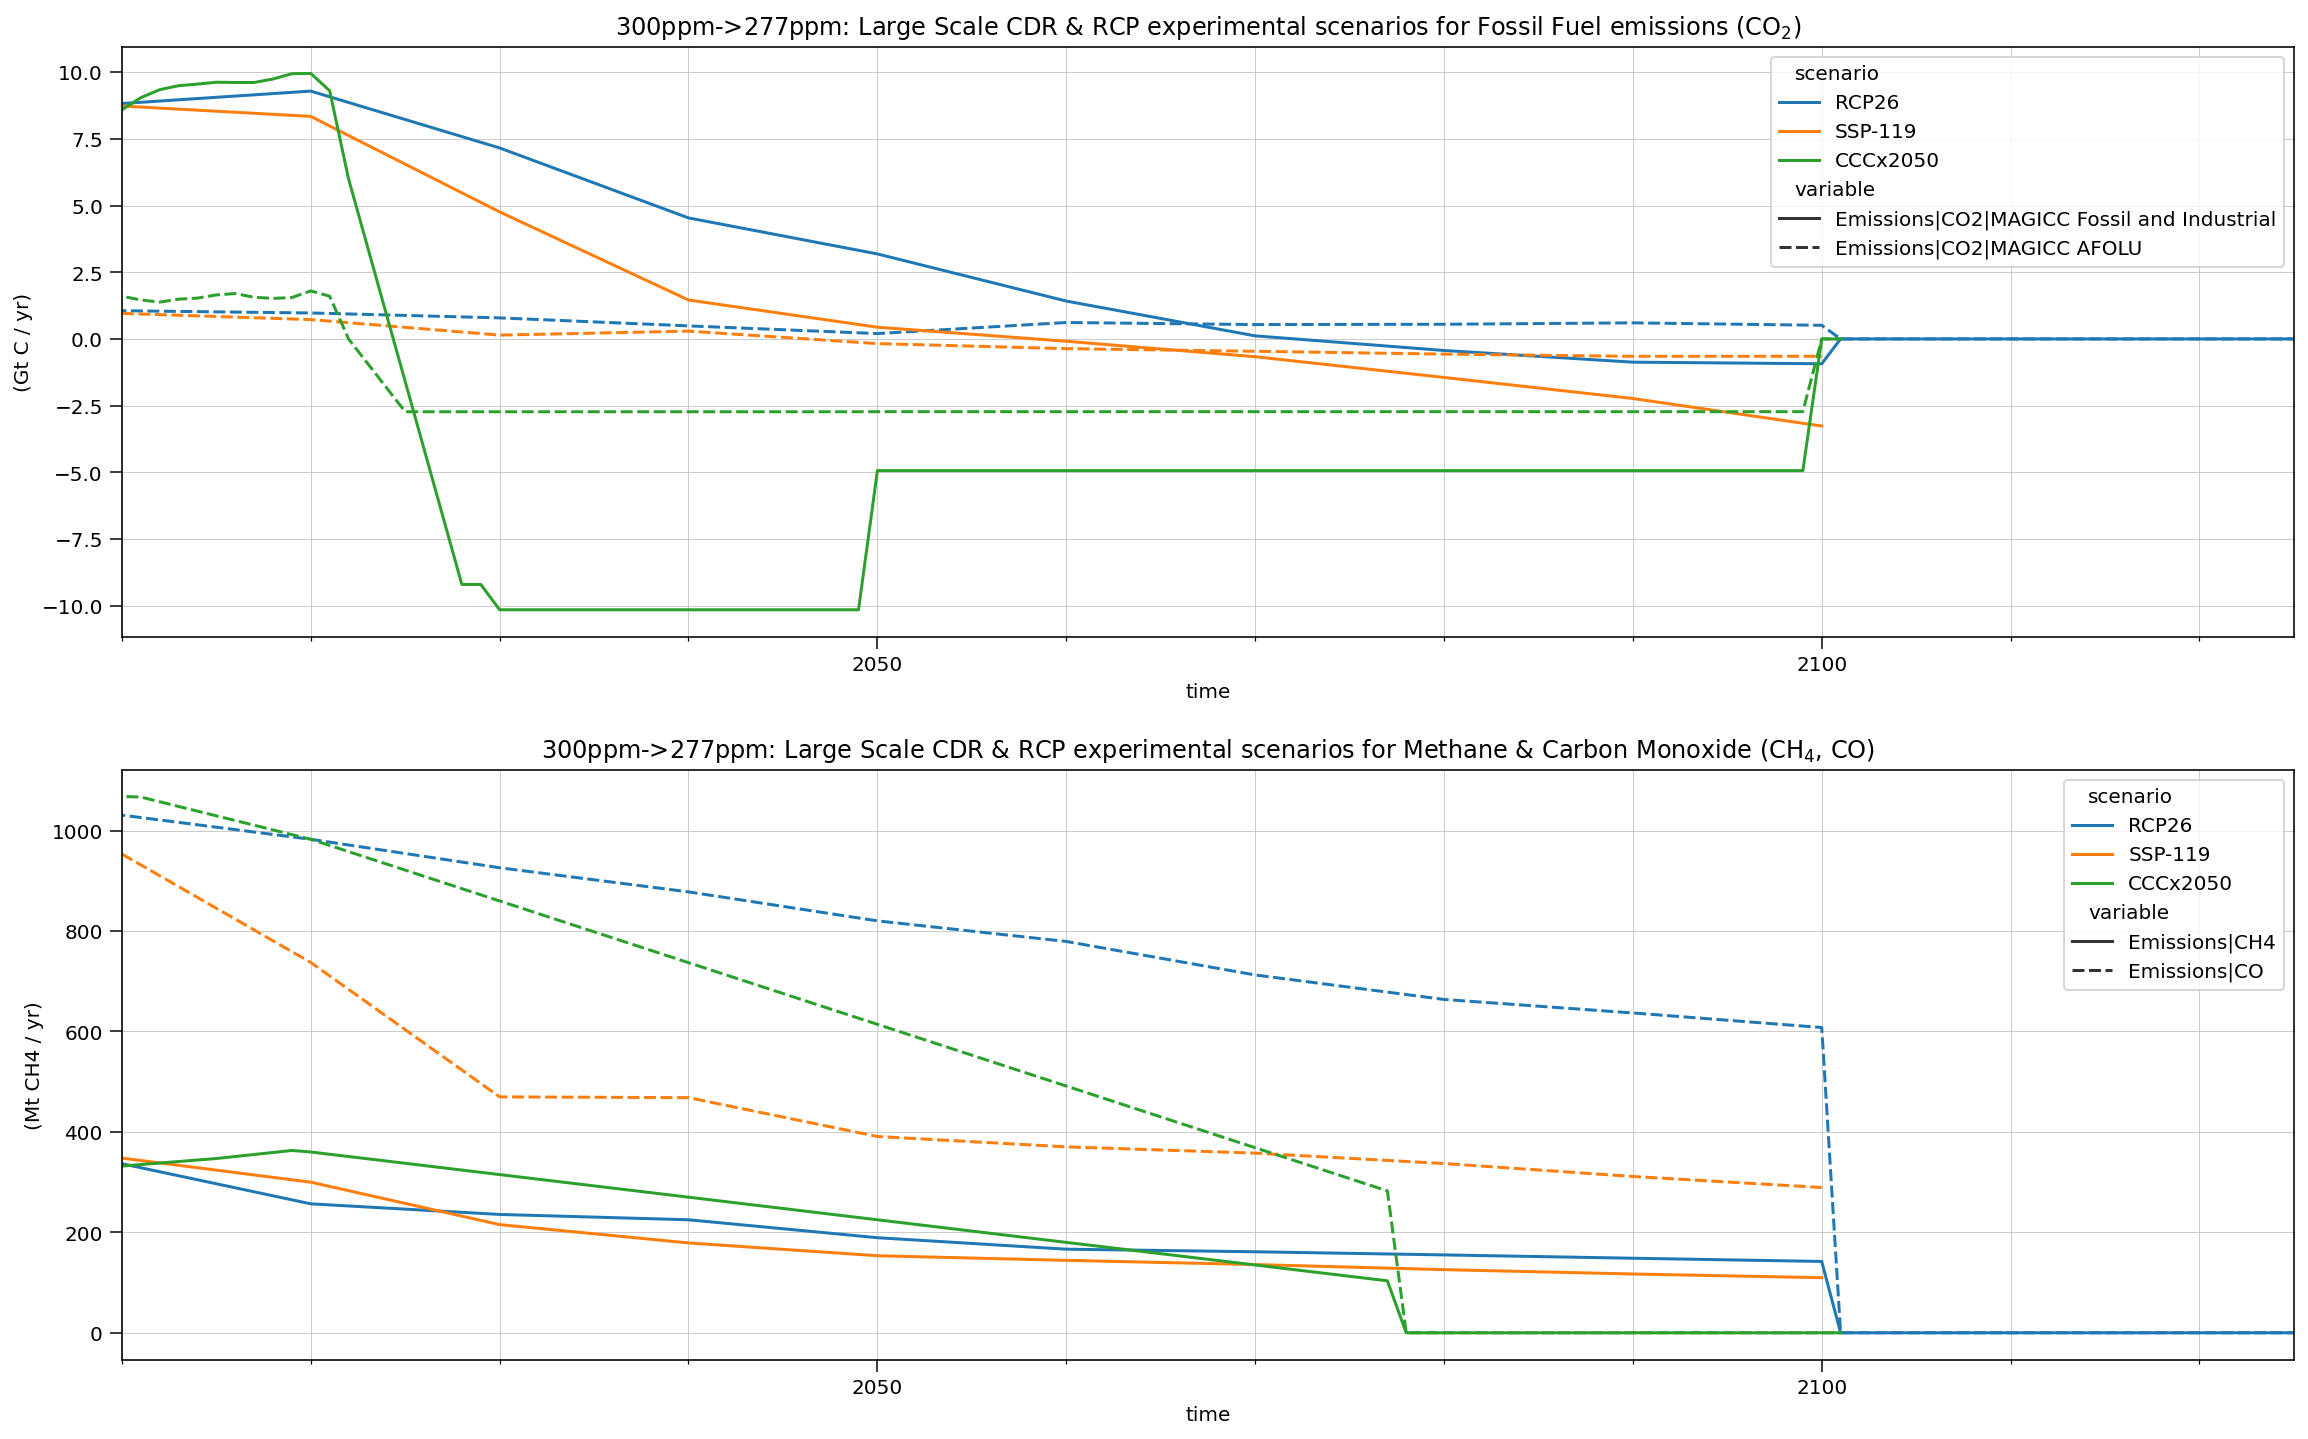

In [25]:
x = (datetime(2000, 1, 1), datetime(magcfg['endyear'], 1, 1))
pret='300ppm->277ppm: Large Scale CDR & RCP experimental scenarios for '
gtgvar = '*CO2|MAGICC Fossil and Industrial', '*CO2|MAGICC AFOLU*'
mtgvar = '*Emissions|CH4', '*Emissions|CO'
list = [gtgvar,mtgvar]
title = [pret + 'Fossil Fuel emissions (CO$_2$)', 
         pret + 'Methane & Carbon Monoxide (CH$_4$, CO)']

mdata = MAGICCData(rcp26)
#declines.append(CCCx2050)
#mdata = mdata.append(CCCx2050)
for scen in (img119, CCCx2050):
    mdata = mdata.append(scen)
fig, axes = plt.subplots(2,1, figsize = (16, 10))
for n,var in enumerate(list):
    varun = var[(n-1)]
    test = mdata.filter(region='World', variable=var).lineplot(hue='scenario', style='variable', ax=axes[n])
    ylab = declines[0].filter(region='World', variable=varun)['unit'].iloc[[0]].all()
    utils.ylab = ylab
    utils.var = title[n]
    utils.plthelpr(axes[n],plt,profile='emiss')

## Running MAGICC

A single `pymagicc` run doesn't take long and returns a Pandas Dict.
(If not on Windows, the very first run might be slower due to setting up Wine.)

In [26]:
pd.set_option('precision', 4)

In [27]:
# Adjust baseline temp to the mean of 1720 to 1800 
# per https://doi.org/10.1175/BAMS-D-16-0007.1
styr = zero_out_temp_start
eyr = zero_out_temp_end
selectftr = { 'region': 'World', 'variable': 'Surface Temperature',
             'year': range(magcfg['startyear'], magcfg['endyear']), }

#### Cache the meanbase line function.

In [28]:
# Mean baseline function

# Could be removed if the following can be reset in magcfg:
#   out_zero_temp_period = 1961, 1990
#   out_zero_heat_period = 1961, 1990
# check the literature if zero_heat_period should be moved in parallel.
    
def meanbln(scen,mgdata,**cfgs):
    pd.set_option('precision', 4)
    origts = mgdata.timeseries()
    default = pymagicc.run(scen, **cfgs)
    pmean = default.filter(**selectftr).timeseries().loc[:,datetime(styr, 1, 1): datetime(eyr, 1, 1)].T.mean()
    defaultts = default.timeseries()
    updated = defaultts.xs((selectftr['variable']),level = ('variable'), drop_level=False).sub(pmean[0])
    origts.loc[updated.index.values] = updated
    return(MAGICCData(origts.copy()))

In [29]:
clvars = ['Surface Temperature']
nrvars = ['Radiative Forcing', 'Atmospheric Concentrations|CO2 Equivalent', 
          'Atmospheric Concentrations|CO2', 'Atmospheric Concentrations|N2O']
anthrovars = ['Emissions|CO2|MAGICC Fossil and Industrial', 'Emissions|CO2|MAGICC AFOLU']
cumulvar = [anthrovars[0]+'|Cumulative', anthrovars[1] + '|Cumulative']
vars = clvars + nrvars + anthrovars + cumulvar + [ 'CLIMSENS_EFF' ]

In [30]:
scenex = 'CCCx2050'
notscen = ['MAGICC6','CDRex','not_relevant']
regionscen = notscen + [ scenex ]
notscenlevels = ['climate_model','model','todo']
regionscenlevels = notscenlevels + ['scenario']
fullscen = regionscen + ['World']
fullscenlevels = regionscenlevels + ['region']

#### After helpers have been setup, run MAGICC

In [31]:
# Run Magicc & create results container for graphs.
#myscen = CCCx2050
#res = ''
#tmprs = pymagicc.run(myscen, **magcfg)
#res = meanbln(myscen, tmprs, **magcfg)

In [32]:
myscen = [ img119, CCCx2050 ]
res = ''
%time res = pymagicc.run(rcp26, **magcfg)  #need to create res of type MAGICCData

CPU times: user 4.66 s, sys: 252 ms, total: 4.91 s
Wall time: 11.9 s


In [33]:
for scen in myscen:
    tmprs = pymagicc.run(scen, **magcfg)
    res = res.append(meanbln(scen, tmprs, **magcfg))

In [34]:
scns = res['scenario'].unique()

#### Generate cumulative emissions graph timepoints

In [35]:
#sn='CCCx2050'
for sn in scns:
    for emis in anthrovars:
        cumurs = res.filter(scenario=sn, variable = emis).timeseries().cumsum(axis=1)
        cumurs = cumurs.rename(index={emis:emis+'|Cumulative'})
        cumurs = cumurs.rename(index={'Gt C / yr':'Cumulative Gt C'})
        res = res.append(cumurs)

### Graph MAGICC results
Units remain in the native MAGICC format of Gt C, to convert multiply by 3.664 to change to Gt $CO_2$. Sharp decreases in temperature and radiative forcing are from volcanic activity. The sharpest dip is known as the Year of Poverty or No Summer in 1816, graphed in MAGICC years as 1/1/1817.

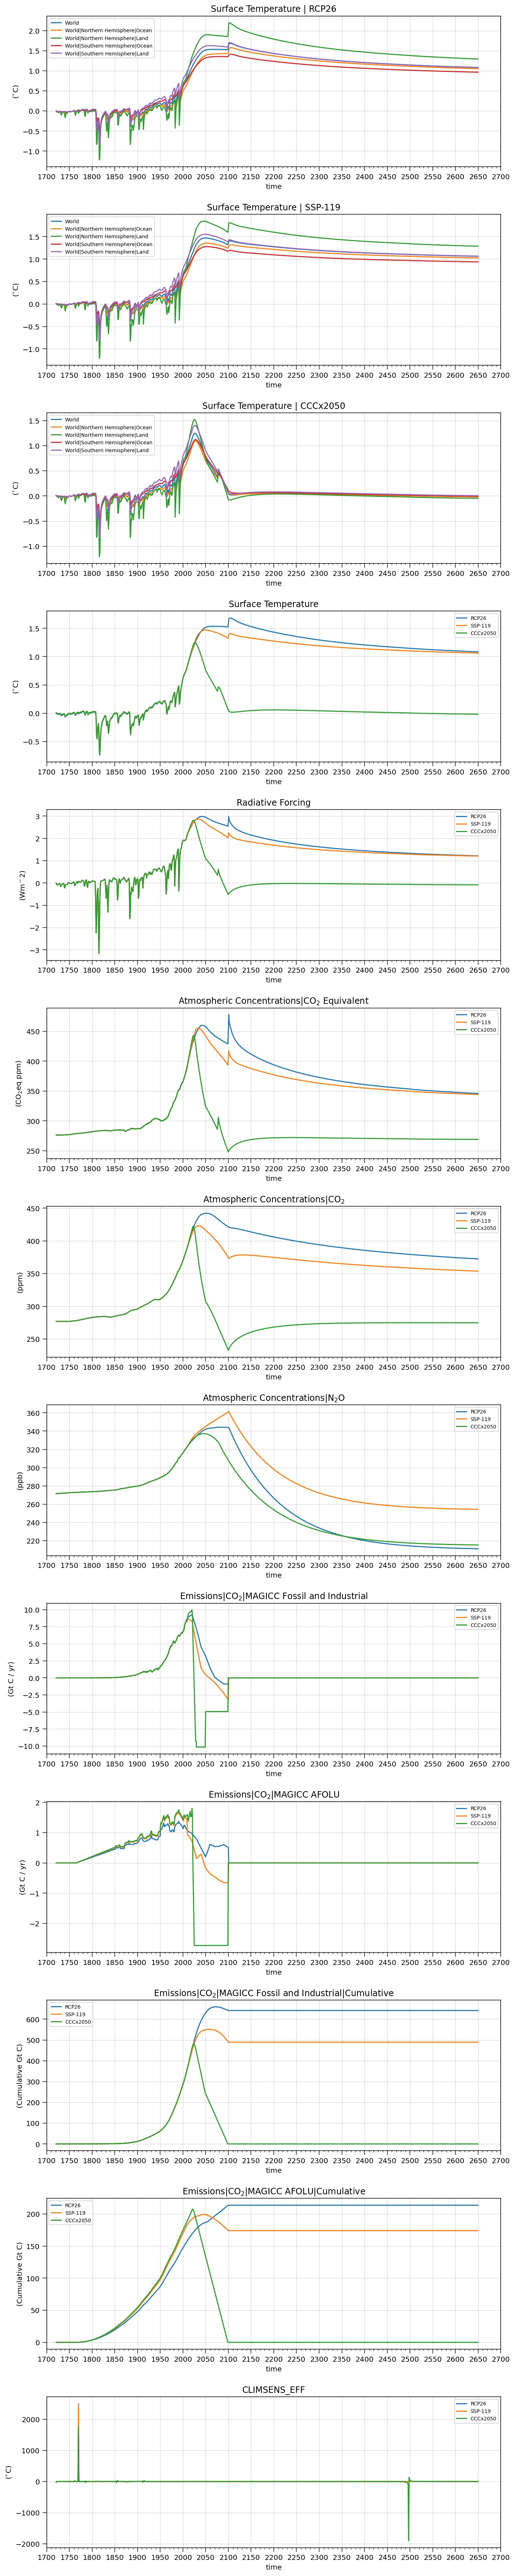

In [36]:
pts = len(vars)+len(scns) 

# Scale figures to 50 yrs per 1°C

#fig, axes = plt.subplots(pts, 1, figsize=(6, 48.75))
fig, axes = plt.subplots(pts, 1, figsize=(10, 50))

for n, scn in enumerate(scns):
    res.filter(variable=clvars, scenario=scn).lineplot(ax=axes[n], hue='region')
    ftsize='x-small'
    axes[n].legend(loc='upper left', fontsize=ftsize)
    utils.ylab = res.filter(variable=clvars)['unit'].iloc[[0]].all()
    if utils.ylab == 'K':
        utils.ylab = '$^{\circ}$C'
    utils.var = clvars[0] + ' | ' + scn
    utils.plthelpr(axes[n],plt,profile='full')

for n, var in enumerate(vars, start=(len(scns))):
    res.filter(variable=var, region='World').lineplot(ax=axes[n], hue='scenario')
    ftsize='x-small'
    axes[n].legend(loc='best', fontsize=ftsize)
    utils.ylab = res.filter(variable=var)['unit'].iloc[[0]].all()
    if utils.ylab == 'K':
        utils.ylab = '$^{\circ}$C'
    elif 'W' in utils.ylab:
        utils.ylab = 'Wm$^-2$'
    elif 'CO2e' in utils.ylab:
        utils.ylab = 'CO$_2$eq ppm'
    if '2' in var:
        st = re.compile(r'(N|O)2')
        utils.var = st.sub(r'\1$_2$',var)
    else:
        utils.var = var
    utils.plthelpr(axes[n],plt,profile='full')

In [37]:
plt.close('all')


# Diagnostic Output
All diagnostics will only be performed on CDR experiment: 300 ppm by 2050, CCCx2050.

### Print $CO_2$ and Temperature Mean for the listed year timespans

In [38]:
mnbls = {
    'mean of 1720-1800': [ 1720, 1800 ],
    'mean of 1850-1900': [ 1850, 1900 ],
    'mean of 1861-1900': [ 1861, 1900 ],
    'mean of 1880-1900': [ 1880, 1900 ],
    'mean of 1951-1980': [ 1951, 1980 ], 
    'mean of 1961-1990': [ 1961, 1990 ]}

varwatch = ['Surface Temperature', 
            'Atmospheric Concentrations|CO2', 
            'Atmospheric Concentrations|CO2 Equivalent']

midx = res.filter(scenario = 'CCCx2050', variable = varwatch, 
                  region = 'World').timeseries().xs(fullscen, level = fullscenlevels)
mndf = pd.DataFrame(columns = mnbls.keys(), index = midx.index)

for key in mnbls.keys():
    # grab a date slice and subtract 1 to move from calendary year to MAGICC year, return span from cal years.
    mydf = res.filter(scenario = 'CCCx2050', variable = varwatch, region='World').timeseries().xs(fullscen, 
                level = fullscenlevels).loc[
                :,datetime(mnbls[key][0]-1,1,1):datetime(mnbls[key][1]-1,1,1)].T.mean()
    mndf[key] = mydf.values

mn1850 = mndf['mean of 1850-1900']
cmns = mndf['mean of 1961-1990'][1] + abs(mn1850[1])        # calendar year
t1849 = res.filter(scenario = 'CCCx2050', variable = 'Surface Temperature', 
            region='World').timeseries().xs(fullscen, level = fullscenlevels).loc[
    :,datetime(1849,1,1)].values.squeeze()
print('\nTemperature at 1850 in calendar yr {:.3f}°C relative to 1720-1800 mean.'.format(t1849))
print('The MAGICC generated difference from 1850-1900 to 1961-1990 is {:.4f}°C'.format(cmns))

mndf


Temperature at 1850 in calendar yr 0.001°C relative to 1720-1800 mean.
The MAGICC generated difference from 1850-1900 to 1961-1990 is 0.2738°C


,,mean of 1720-1800,mean of 1850-1900,mean of 1861-1900,mean of 1880-1900,mean of 1951-1980,mean of 1961-1990
unit,variable,,,,,,
ppm,Atmospheric Concentrations|CO2,278.5890,289.6549,290.8325,293.6524,321.4195,332.2588
K,Surface Temperature,-0.0007,-0.0634,-0.0705,-0.1258,0.1718,0.2104
CO2eqppm,Atmospheric Concentrations|CO2 Equivalent,278.2386,285.1126,285.2560,286.3614,309.0205,321.9121


### MAGICC and HadCRUT5 comparison
Return the HadCRUT5 means for 1850-1900, and 1961-1990, and mean for the 2015-2020.
List MAGICC output for 2015-2020 with the 1850-1900 baseline in addition to the 1720-1800 baseline.

HadCRUT5 data from: An updated assessment of near-surface temperature change from 1850: the HadCRUT5 dataset. Journal of Geophysical Research (Atmospheres), Morice, C.P., J.J. Kennedy, N.A. Rayner, J.P. Winn, E. Hogan, R.E. Killick, R.J.H. Dunn, T.J. Osborn, P.D. Jones and I.R. Simpson, https://doi.org/10.1029/2019JD032361
https://crudata.uea.ac.uk/cru/data/temperature/

In [39]:
ev1850 = np.arange(0,100, 2) 
ev1961 = np.arange(222,280,2)
ev2015 = np.arange(330,340,2)
idxs = ['gl', 'nh', 'sh']
hd5df = pd.DataFrame( index = ['World','Northern Hemisphere', 'Southern Hemisphere' ],
            columns = ['H1850-1900', 'H1961-1990', 'H2015-2020', 'H2015-2020 1850', 'H2015-2020 1720'])
for n, st in enumerate (idxs):
    txt = join(SCEN_DIR,'HadCRUT5.0Analysis_'+st+'.txt')
    pdf = pd.read_fwf(txt,sep=' ', 
            names=['Year',1,2,3,4,5,6,7,8,9,10,11,12,'Ave']).xs(['Year','Ave'], axis=1, drop_level=False)
    hd5df.iloc[n, 0] = pdf['Ave'][ev1850].T.mean()
    hd5df.iloc[n, 1] = pdf['Ave'][ev1961].T.mean()
    hd5df.iloc[n, 2] = pdf['Ave'][ev2015].T.mean()
    hd5df.iloc[n, 3] = hd5df.iloc[n, 2] + abs(hd5df.iloc[n, 0])
    hd5df.iloc[n, 4] = hd5df.iloc[n, 3] + mn1850[1]
tmm = res.filter(variable = 'Surface Temperature').timeseries().xs(regionscen, 
        level = regionscenlevels).xs(['Surface Temperature','K'], 
        level=['variable', 'unit'],drop_level=True).loc[:,datetime(2016,1,1):datetime(2021,1,1)].T.mean()
cmm = tmm - mn1850[1]
mgd = pd.DataFrame(index = tmm.index, columns = ['1850-19mn','1720-18mn'])
mgd['1720-18mn'] = tmm.values
mgd['1850-19mn'] = cmm.values
hd5df['MG 1850'] = [cmm[0], ((mgd.iloc[1]['1850-19mn']+mgd.iloc[2]['1850-19mn'])/2), 
                     ((mgd.iloc[3]['1850-19mn']+mgd.iloc[4]['1850-19mn'])/2) ]
hd5df['MG 1720'] = [tmm[0], ((mgd.iloc[1]['1720-18mn']+mgd.iloc[2]['1720-18mn'])/2),
                     ((mgd.iloc[3]['1720-18mn']+mgd.iloc[4]['1720-18mn'])/2) ]
hd5df['mg ∆ 1850'] = hd5df['H2015-2020 1850'] - hd5df['MG 1850']
hd5df['mg ∆ 1720'] = hd5df['H2015-2020 1720'] - hd5df['MG 1720']
print('HadCRUT5 Temperature Means listed in the calendar year.')
hd5df.style

HadCRUT5 Temperature Means listed in the calendar year.


,H1850-1900,H1961-1990,H2015-2020,H2015-2020 1850,H2015-2020 1720,MG 1850,MG 1720,mg ∆ 1850,mg ∆ 1720
World,-0.3589,-0.0046,0.8514,1.2103,1.1469,1.1551,1.0916,0.0553,0.0553
Northern Hemisphere,-0.3709,-0.0150,1.1210,1.4919,1.4285,1.1979,1.1345,0.2940,0.2940
Southern Hemisphere,-0.3470,0.0059,0.5818,0.9288,0.8653,1.1816,1.1182,-0.2529,-0.2529


In [40]:
mgd.style

,1850-19mn,1720-18mn
region,,
World,1.1551,1.0916
World|Northern Hemisphere|Ocean,0.9992,0.9357
World|Northern Hemisphere|Land,1.3967,1.3333
World|Southern Hemisphere|Ocean,1.0460,0.9826
World|Southern Hemisphere|Land,1.3172,1.2538


### Return the lowest temperature in the time-series

In [41]:
rts = res.timeseries()
scen, df = utils.finddate('Surface Temperature', 'min', rts, 1720, 'CCCx2050')
print(scen)
df

CCCx2050


,time,1816-01-01,1817-01-01
region,unit,,
World,K,-0.6662,-0.7295
World|Northern Hemisphere|Ocean,K,-0.4711,-0.6022
World|Northern Hemisphere|Land,K,-1.2089,-1.1555
World|Southern Hemisphere|Ocean,K,-0.3918,-0.5066
World|Southern Hemisphere|Land,K,-0.8056,-0.8095


### Return the lowest temperature after 2005

In [42]:
scen, df = utils.finddate('Surface Temperature', 'min', rts, 2005)
print(scen)
df

CCCx2050


,time,2103-01-01 00:00:00,2650-01-01 00:00:00
region,unit,,
World,K,0.0257,-0.0178
World|Northern Hemisphere|Ocean,K,0.0375,-0.0193
World|Northern Hemisphere|Land,K,-0.0798,-0.0476
World|Southern Hemisphere|Ocean,K,0.0810,-0.0046
World|Southern Hemisphere|Land,K,0.0457,0.0049


### Return the highest temperature until the series end in the 2600s

In [43]:
scen, df = utils.finddate('Surface Temperature', 'max', rts)
print(scen)
yr = df.columns[0]
df.sort_values(yr,ascending=False)

CCCx2050


,time,2025-01-01,2026-01-01,2027-01-01,2028-01-01
region,unit,,,,
World|Northern Hemisphere|Land,K,1.5184,1.5181,1.5101,1.4944
World|Southern Hemisphere|Land,K,1.3985,1.4038,1.4037,1.3983
World,K,1.2393,1.2455,1.2465,1.2425
World|Southern Hemisphere|Ocean,K,1.1065,1.1155,1.1206,1.1220
World|Northern Hemisphere|Ocean,K,1.0832,1.0923,1.0967,1.0966


### Detail warming including calibration points of 2015-2020, and peak timeframe 2027-2028

In [44]:
res.filter(variable = 'Surface Temperature').timeseries().xs(regionscen, 
        level = regionscenlevels).loc[:,datetime(2016,1,1):datetime(2039,1,1)].style

,,time,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00,2020-01-01 00:00:00,2021-01-01 00:00:00,2022-01-01 00:00:00,2023-01-01 00:00:00,2024-01-01 00:00:00,2025-01-01 00:00:00,2026-01-01 00:00:00,2027-01-01 00:00:00,2028-01-01 00:00:00,2029-01-01 00:00:00,2030-01-01 00:00:00,2031-01-01 00:00:00,2032-01-01 00:00:00,2033-01-01 00:00:00,2034-01-01 00:00:00,2035-01-01 00:00:00,2036-01-01 00:00:00,2037-01-01 00:00:00,2038-01-01 00:00:00,2039-01-01 00:00:00
region,unit,variable,,,,,,,,,,,,,,,,,,,,,,,,
World,K,Surface Temperature,1.0189,1.0489,1.0788,1.1073,1.1343,1.1618,1.1884,1.2103,1.2274,1.2393,1.2455,1.2465,1.2425,1.2333,1.2212,1.2062,1.1894,1.1712,1.1518,1.1315,1.1103,1.0884,1.0659,1.0428
World|Northern Hemisphere|Ocean,K,Surface Temperature,0.8661,0.8944,0.9229,0.9506,0.9771,1.0032,1.0287,1.0511,1.0694,1.0832,1.0923,1.0967,1.0966,1.0918,1.0838,1.0730,1.0602,1.0457,1.0300,1.0132,0.9955,0.9770,0.9578,0.9381
World|Northern Hemisphere|Land,K,Surface Temperature,1.2279,1.2728,1.3176,1.3574,1.3933,1.4306,1.4662,1.4919,1.5095,1.5184,1.5181,1.5101,1.4944,1.4710,1.4450,1.4154,1.3842,1.3519,1.3187,1.2847,1.2501,1.2149,1.1793,1.1433
World|Southern Hemisphere|Ocean,K,Surface Temperature,0.9281,0.9499,0.9718,0.9936,1.0153,1.0370,1.0584,1.0777,1.0938,1.1065,1.1155,1.1206,1.1220,1.1196,1.1144,1.1067,1.0971,1.0860,1.0736,1.0602,1.0459,1.0307,1.0149,0.9984
World|Southern Hemisphere|Land,K,Surface Temperature,1.1852,1.2128,1.2404,1.2677,1.2945,1.3222,1.3491,1.3707,1.3874,1.3985,1.4038,1.4037,1.3983,1.3877,1.3745,1.3584,1.3405,1.3214,1.3011,1.2799,1.2578,1.2351,1.2117,1.1878


### Show $CO_2$ concentration for calibration 2015-2020

In [45]:
res.filter(variable = 'Atmospheric Concentrations|CO2').timeseries().xs(fullscen, 
        level = fullscenlevels).loc[:,datetime(2016,1,1):datetime(2022,1,1)]

,time,2016-01-01 00:00:00,2017-01-01 00:00:00,2018-01-01 00:00:00,2019-01-01 00:00:00,2020-01-01 00:00:00,2021-01-01 00:00:00,2022-01-01 00:00:00
unit,variable,,,,,,,
ppm,Atmospheric Concentrations|CO2,406.5393,409.2128,411.7993,414.4126,417.1119,419.9064,422.2885


### Show $CO_2$ concentration during peak carbon.

In [46]:
res.filter(variable = 'Atmospheric Concentrations|CO2').timeseries().xs(fullscen, 
        level = fullscenlevels).loc[:,datetime(2023,1,1):datetime(2028,1,1)]

,time,2023-01-01 00:00:00,2024-01-01 00:00:00,2025-01-01 00:00:00,2026-01-01 00:00:00,2027-01-01 00:00:00,2028-01-01 00:00:00
unit,variable,,,,,,
ppm,Atmospheric Concentrations|CO2,422.4777,421.3316,418.8491,415.0986,410.5364,405.1632


### Show years after CR to see how temperature responds.

In [47]:
res.filter(variable = 'Surface Temperature').timeseries().xs(regionscen, 
        level = regionscenlevels).loc[:,datetime(2101,1,1):datetime(2107,1,1)].style

,,time,2101-01-01 00:00:00,2102-01-01 00:00:00,2103-01-01 00:00:00,2104-01-01 00:00:00,2105-01-01 00:00:00,2106-01-01 00:00:00,2107-01-01 00:00:00
region,unit,variable,,,,,,,
World,K,Surface Temperature,0.0368,0.0302,0.0257,0.0226,0.0205,0.0191,0.0183
World|Northern Hemisphere|Ocean,K,Surface Temperature,0.0520,0.0434,0.0375,0.0332,0.0301,0.0278,0.0262
World|Northern Hemisphere|Land,K,Surface Temperature,-0.0779,-0.0798,-0.0798,-0.0787,-0.0771,-0.0749,-0.0726
World|Southern Hemisphere|Ocean,K,Surface Temperature,0.0965,0.0876,0.0810,0.0758,0.0718,0.0685,0.0659
World|Southern Hemisphere|Land,K,Surface Temperature,0.0552,0.0495,0.0457,0.0431,0.0414,0.0403,0.0397


### Diagnostic Summary Tables

In [48]:
pd.set_option('precision', 4)
dates = [ datetime(1751,1,1,0), datetime(1851,1,1,0), datetime(2022,1,1,0), datetime(2024,1,1,0), 
         datetime(2051,1,1,0), datetime(2082,1,1,0), datetime(2101,1,1,0), datetime(2258,1,1,0), 
         datetime(magcfg['endyear'],1,1,0) ]
strs = (res.filter(variable = vars, region='World'
                     ).timeseries().loc[:,dates])
strs = strs.xs( ['MAGICC6','World','not_relevant'], level = ['climate_model','region','todo'], drop_level=True)
lmdts = res.filter(variable = vars, region='World'
                     ).timeseries().xs( 
    ['MAGICC6','World','not_relevant'], level = ['climate_model','region','todo'], 
    drop_level=True).loc[:,datetime(2082,1,1,0):datetime(2101,1,1,0)].mean(1)
lmdst = lmdts.xs(['Surface Temperature'], level = ['variable'], drop_level=False)
strs['2081-2100 mean'] = lmdts
strs['2081-2100 calmean'] = lmdst.add(abs(mn1850[1]))
#strs.loc[:,[datetime(1751,1,1,0),datetime(1851,1,1,0),datetime(2101,1,1,0),'2081-2100 mean', '2081-2100 calmean']]
strs.style

In [49]:
res.filter(variable=['*Concentrations|CO2*', '*Emissions|CO2|*', 'Surface Temperature'], region='World', scenario='RCP26').timeseries().loc[:,datetime(1721,1,1,0):datetime(1766,1,1,0)].style

#### Verify all cumulative emissions are removed

In [50]:
pd.set_option('precision', 16)
res.filter(variable='Emissions|CO2|MAGICC*Cumulative', region='World').timeseries().xs(fullscen, 
        level = fullscenlevels).loc[:,datetime(2101,1,1)]

unit             variable                                             
Cumulative Gt C  Emissions|CO2|MAGICC Fossil and Industrial|Cumulative    0.0000944183005025
                 Emissions|CO2|MAGICC AFOLU|Cumulative                   -0.0029086933003937
Name: 2101-01-01 00:00:00, dtype: float64

In [51]:
pd.set_option('precision', 4)


### Show maximum and minimum $CO_2$ concentration and Surface Temperature post 2100.

In [52]:
varwatch = ('Atmospheric Concentrations|CO2', 'Surface Temperature')
mydf = []
ddf = pd.DataFrame()
for myvar in varwatch:
    for func in ('max', 'min'):
        scen, mydf = utils.finddate(myvar, func, res.filter(region='World', scenario=scenex).timeseries(), 2100 )
        mydf = mydf.xs('World', level = 'region', drop_level=True)
        rows = np.append(mydf.index.values, myvar)
        rwhdr = np.append(mydf.index.names, 'variable')
        midx = pd.MultiIndex.from_frame(pd.DataFrame([rows], columns=rwhdr))
        ddf = ddf.append(pd.DataFrame(mydf.values, columns=mydf.columns, index=midx))
ddf

2100-01-01 00:00:00  2200-01-01 00:00:00  \
unit variable                                                                   
ppm  Atmospheric Concentrations|CO2                  NaN                  NaN   
     Atmospheric Concentrations|CO2             232.6457                  NaN   
K    Surface Temperature                             NaN               0.0579   
     Surface Temperature                             NaN                  NaN   

                                     2505-01-01 00:00:00  2650-01-01 00:00:00  
unit variable                                                                  
ppm  Atmospheric Concentrations|CO2             274.8714                  NaN  
     Atmospheric Concentrations|CO2                  NaN                  NaN  
K    Surface Temperature                             NaN                  NaN  
     Surface Temperature                             NaN              -0.0178

##### Show Detected Climate Sensitivity minimum and maximum data

In [53]:
csres = res.filter(region='World', scenario=scenex).timeseries()
scen, csdf = utils.finddate('CLIMSENS_EFF', 'min', csres, 2100)
csdf

,time,2497-01-01 00:00:00
region,unit,
World,K,-1899.3371


In [54]:
scen, csdf = utils.finddate('CLIMSENS_EFF', 'max', csres, 2100)
csdf

,time,2498-01-01 00:00:00
region,unit,
World,K,138.8647


#### Debugging Output
Uncomment and run to obtain details for specific problematic gasses.

In [55]:
#for glob in 'Land-use', 'Mineral Dust', 'Indirect', '143a', 'HCFC22', '141b', 'Halon1301':
#    debugdf = res.filter(region='World', 
#                        variable='*' + glob + '*').timeseries().xs([
#                    'MAGICC6','CDRex','not_relevant','World','CCCx2050'], 
#                    level = ['climate_model','model','todo','region','scenario']).loc[:,datetime(2005,1,1):datetime(2662,1,1)]
#    print(debugdf.T.min(), debugdf.T.max())
#debugdf.style

#Radiative Forcing|Aerosols|Direct Effect|Mineral Dust .0003

In [56]:
#dfdebug2050 = res.filter(region='World', scenario='CCCx2050').timeseries().xs([
#    'MAGICC6','CDRex','World','CCCx2050','not_relevant'], 
#    level = ['climate_model','model','region','scenario','todo'])
#newdf = dfdebug2050.loc[ 
#        (dfdebug2050[ datetime(2662,1,1,0)] > 0.00001) ]
#newdf.loc[:,datetime(2200,1,1,0):datetime(2300,1,1,0)].sort_index().style

In [57]:
# What's causing that bounce back where as the 
# rest of the graph is decreasing?
# Uncomment this block and run. It will show
# a stack of gasses that are increasing due to 
# definations in WMO2006_ODS_A1Baseline.prn
# The dates of the growth moves based on stFF

#dfdebug2050 = res.filter(
#    scenario='CCCx2050',region='World').timeseries().xs([
#    'MAGICC6','CDRex','World','CCCx2050','not_relevant'], 
#    level = ['climate_model','model','region','scenario','todo'])
#newdf = dfdebug2050.loc[ (dfdebug2050[ datetime(stFF-3,1,1,0)] < dfdebug2050[datetime(stFF,1,1,0)]) & (dfdebug2050[ datetime(2100,1,1,0)] > 0) ]
#newdf.loc[:,datetime(stFF-3,1,1,0):datetime(stFF+10,1,1,0)].sort_index().style

#### Basic Climate Sensitivity Fitting Exercise

This uses the MAGICC temperature data relative to 1720-1800 mean and $CO_2$ concentration to extrapolate a curve scaled to identify the temperature at one doubling of $CO_2$. If we continue to emitt exponentally, it will drive $CO_2$ concentration exponetially upward and temperature as well.

Note, $CO_2$ measured atmospheric concentrations in blue doesn't move, only temperature in respect to core_sensitivity. The fitting execrcise is to show how closely temperatures match both estimated sensitivty and HadCRUT5 (2021) analysis.

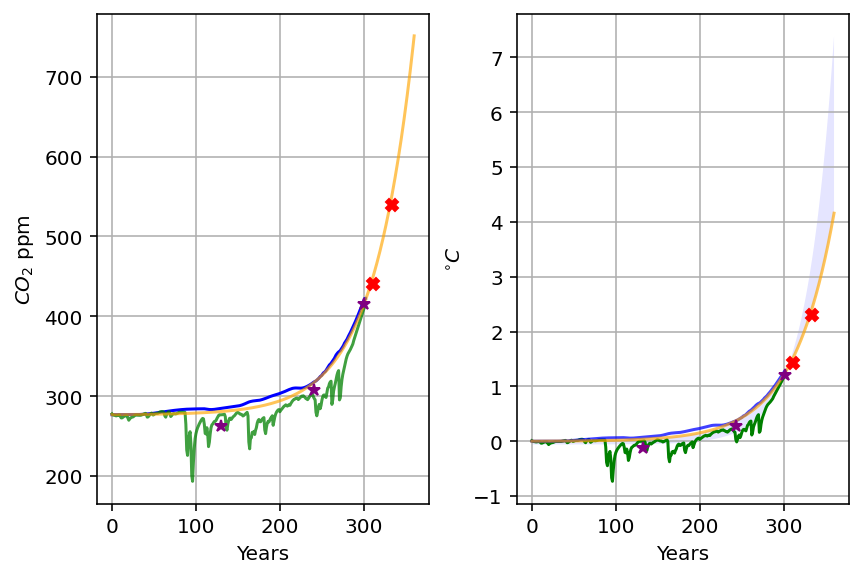

Years are internal MAGICC years unless listed otherwise, subtract 1 from the year to convert to calendar year.
Red Xes at 450 and 552 ppm.


,0,96,130,241,300
dates,1721.0000,1817.0000,1851.0000,1962.0000,2021.0000
CO2,277.0000,284.1080,284.9500,318.1300,419.9064
Temperature,0.0108,-0.7295,0.0013,0.1784,1.1618


In [58]:
from scipy.optimize import curve_fit
def exp_fit(x, a, b, c):
    y = a*np.exp(b*x) + c
    return y

myvars = ['Atmospheric Concentrations|CO2', 'Surface Temperature']
# HadCRUT5 Global Temperature for 1850, 1961, 2020, based around the mean of 1961-1990
hadCRUT5 = [-0.418, -0.020, 0.922]      #hadCRUT5 GL, cal yr, 1961-1990 baseline
mhd = hadCRUT5 + abs(hd5df.iloc[0, 0])  #hadCRUT5 GL, cal yr, 1850-1900 baseline
mmhd = mhd + mn1850[1]   #hadCRUT5 GL, cal yr, relative to 1720-1800

xvals = np.arange(303)
dfco2 = res.filter(variable = myvars[0], region='World', scenario=scenex).timeseries()
dftemp = res.filter(variable = myvars[1], region='World', scenario=scenex).timeseries()
offset = res.filter(variable = myvars[1], region='World', scenario=scenex).timeseries().columns[0]
yrset = offset.year
yrco2ppm = dfco2.values.squeeze()[:303]
yrtemp = dftemp.values.squeeze()[:303]
popts = (.2715, .0206, 276.744)
topts = (114)
sc = 1.2
tsttmp, tstcov = curve_fit(exp_fit, xvals, yrtemp, p0=[popts[0]/topts, popts[1], 0])
co2fit = exp_fit(xvals*sc, *popts)
tempfit = exp_fit(xvals*sc, popts[0]/topts, popts[1], 0)
tempfit2 = exp_fit(xvals*sc, *tsttmp)

idxyr = [259, 278]
cpts = [co2fit[idxyr[0]], co2fit[idxyr[1]]]
tpts = [tempfit[idxyr[0]], tempfit[idxyr[1]]]
extdf = pd.DataFrame()
extdf['dates'] = xvals+yrset
extdf['CO2'] = yrco2ppm
extdf['Temperature'] = yrtemp
extdf = extdf.T
scdf = pd.DataFrame()
scdf['dates|extrapolate'] = (xvals[0:301])*sc+yrset
scdf['CO2|extrapolate'] = co2fit[2:303]
scdf['Temperature|extrapolate'] = tempfit[2:303]
scdf['Temperature|extrapolate2'] = tempfit2[0:301]
scdf = scdf.T
dts = [ 0, 1817-yrset, 1851-yrset, 1962-yrset, -3 ]
sdts = [ 0, 1851/sc-yrset/sc, 2022/sc-yrset/sc, 2023/sc-yrset/sc, 2032/sc-yrset/sc, 
        2033/sc-yrset/sc, 2055/sc-yrset/sc, 2056/sc-yrset/sc ]
prt = extdf.iloc[:,dts]
sprt = scdf.iloc[:,sdts]

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(xvals, yrco2ppm, color = 'blue')
ax1.plot(xvals, (topts*yrtemp)+popts[2], color = 'green', alpha=.75)
ax1.plot(xvals[0:301]*sc, scdf.iloc[1], color = 'orange', alpha=.65)
ax1.plot(xvals[[130,241,300]], (topts*mmhd)+popts[2], '*' , color = 'purple')
ax1.plot([xvals[idxyr[0]]*sc, xvals[idxyr[1]]*sc], cpts, 'X', color = 'red')
ax1.set_xlabel('Years'), ax1.set_ylabel('$CO_2$ ppm')
ax1.grid()
ax2.plot(xvals, yrtemp, color = 'green')
ax2.plot(xvals, (1/topts*yrco2ppm)-popts[2]/topts, color = 'blue', alpha=.75)
ax2.plot(xvals[0:301]*sc, scdf.iloc[2], color = 'orange', alpha=.65)
ax2.plot(xvals[[132,243,302]], mmhd, '*' , color = 'purple')
ax2.plot([xvals[idxyr[0]]*sc, xvals[idxyr[1]]*sc], tpts, 'X', color = 'red')
ax2.fill_between(xvals[0:301]*sc, scdf.iloc[2], scdf.iloc[3], facecolor='blue', alpha=.10)
ax2.set_xlabel('Years'), ax2.set_ylabel('$^{\circ}C$')
ax2.grid()
plt.tight_layout(pad=0.6, h_pad=1.5)
plt.show()
print('Years are internal MAGICC years unless listed otherwise, subtract\
 1 from the year to convert to calendar year.\nRed Xes at 450 and 552 ppm.')
plt.close('all')
prt.style

In [59]:
sprt.style

,0,108,250,251,259,260,278,279
dates|extrapolate,1721.0000,1850.6000,2021.0000,2022.2000,2031.8000,2033.0000,2054.6000,2055.8000
CO2|extrapolate,277.0293,280.8622,414.5224,417.9708,448.8528,453.1604,552.0290,558.9188
Temperature|extrapolate,0.0025,0.0361,1.2086,1.2388,1.5097,1.5475,2.4148,2.4752
Temperature|extrapolate2,-0.0581,-0.0511,1.1590,1.2039,1.6283,1.6906,3.2993,3.4232


In [60]:
print('HadCRUT5 and the following uses the calendar year.')
print('HadCRUT5, 1961-1990 mean | 1850 {}°C,  1961 {}°C,  2020 {}°C'.format(hadCRUT5[0],hadCRUT5[1],hadCRUT5[2]))
print('HadCRUT5, 1850-1900 mean | 1850 {:.4f}°C, 1961 {:.4f}°C, 2020 {:.4f}°C'.format(mhd[0],mhd[1],mhd[2]))
print('HadCRUT5+MAGICC, 1750-1800 mean | 1850 {:.4f}°C, 1961 {:.4f}°C, 2020 {:.4f}°C\n'.format(mmhd[0],mmhd[1],mmhd[2]))
print('2x CO₂ is 276.744*2 = {} ppm.'.format(276.744*2))
print('Fit1 {:.4f} ppm, {:.3f}°C predicted at year {:.0f}.'.format(scdf.iloc[1, 278], 
        scdf.iloc[2, 278], 278*sc+yrset-2))
print('Fit2 {:.4f} ppm, {:.3f}°C predicted at year {:.0f}.'.format(scdf.iloc[1, 278], 
        scdf.iloc[3, 278], 278*sc+yrset-2))

HadCRUT5 and the following uses the calendar year.
HadCRUT5, 1961-1990 mean | 1850 -0.418°C,  1961 -0.02°C,  2020 0.922°C
HadCRUT5, 1850-1900 mean | 1850 -0.0591°C, 1961 0.3389°C, 2020 1.2809°C
HadCRUT5+MAGICC, 1750-1800 mean | 1850 -0.1225°C, 1961 0.2755°C, 2020 1.2175°C

2x CO₂ is 276.744*2 = 553.488 ppm.
Fit1 552.0290 ppm, 2.415°C predicted at year 2053.
Fit2 552.0290 ppm, 3.299°C predicted at year 2053.


### Display detected Equlibrium Climate Sensitivity, Transient Climate Response, Transient Climate Response to cumulative Emissions

Caculate the ECS, TCR, TCRE values for both the positive and negative emissions. Calculations based off of abrupt-2xCO2, 1pctCO2, and abrupt-0p5xCO2, 1pctCO2-cdr CMIP6 and CDRMIP experiments, and the current MAGICC settings from magcfg. Non relevant magcfg settings are ignored.

1pctCO2: https://view.es-doc.org/?renderMethod=id&project=cmip6&id=74a0936a-68d6-4c5b-8acc-ac9f31c8a8bd&version=1&client=esdoc-search

abrupt-2xCO2: https://view.es-doc.org/?renderMethod=id&project=cmip6&id=af20c84a-35b1-4b5a-9013-3039390c286e&version=1&client=esdoc-search

1pctCO2-cdr: https://view.es-doc.org/?renderMethod=id&project=cmip6&id=6a465822-ac43-4b3e-beb4-388d291860d4&version=1&client=esdoc-search

abrupt-0p5xCO2: https://view.es-doc.org/?renderMethod=id&project=cmip6&id=8ff7a328-e031-49f1-862c-68be2c5648e8&version=1&client=esdoc-search

In [61]:
sitv = magcfg['core_climatesensitivity']
for test in 'pos', 'neg':
    resultsdata = utils.diagnose_tcr_ecs_tcre(test, 
        CORE_CLIMATESENSITIVITY=sitv,
        CORE_DELQ2XCO2=3.71, **magcfg)
    print("TCR is {tcr:.4f}, ECS is {ecs:.4f} and TCRE is {tcre[0]:.6f} {tcre[1]}".format(
                **resultsdata))

Calculating ECS from abrupt-2xCO2.
Calculating TCR & TCRE from 1pctCO2.
TCR is 2.1057, ECS is 3.2795 kelvin and TCRE is 2.440287 kelvin / 1000 GtC
Calculating ECS from abrupt-0p5xCO2.
Calculating TCR & TCRE from 1pctCO2-cdr.
TCR is 2.1057, ECS is 3.2985 kelvin and TCRE is 2.440287 kelvin / 1000 GtC


### Display temperature response with custom sensitivities over the entire time-series.
The default climate sensitivity is set to 3.45 K, which allows a tuned model output to roughly match the HadCRUT5 global temperature mean for the years 2015-2020.

#### Setup sensitivities for the last graph

In [62]:
lsitv = (sitv - 1.15)
lsitv = float('{:1.4}'.format(lsitv))
hsitv = (sitv + 1.15)
hsitv = float('{:1.4}'.format(hsitv))
runs = {'default': sitv, 'low': lsitv, 'high': hsitv }

In [63]:
# Pull the sensitivites defined in runs.
myscenario = CCCx2050
runsdf = {}
mcfg = magcfg.copy()

def calc_msensi(runs, myscenario):
    for rn in runs:
        mcfg['core_climatesensitivity'] = runs[rn]
        newrn = pymagicc.run(myscenario, **mcfg)
        runsdf[rn] = meanbln(myscenario, newrn, **mcfg)
    return(runsdf)

runsdf = calc_msensi(runs, myscenario)

In [64]:
filtering = {'variable': 'Surface Temperature', 
             'year': range(1720, magcfg['endyear'])}

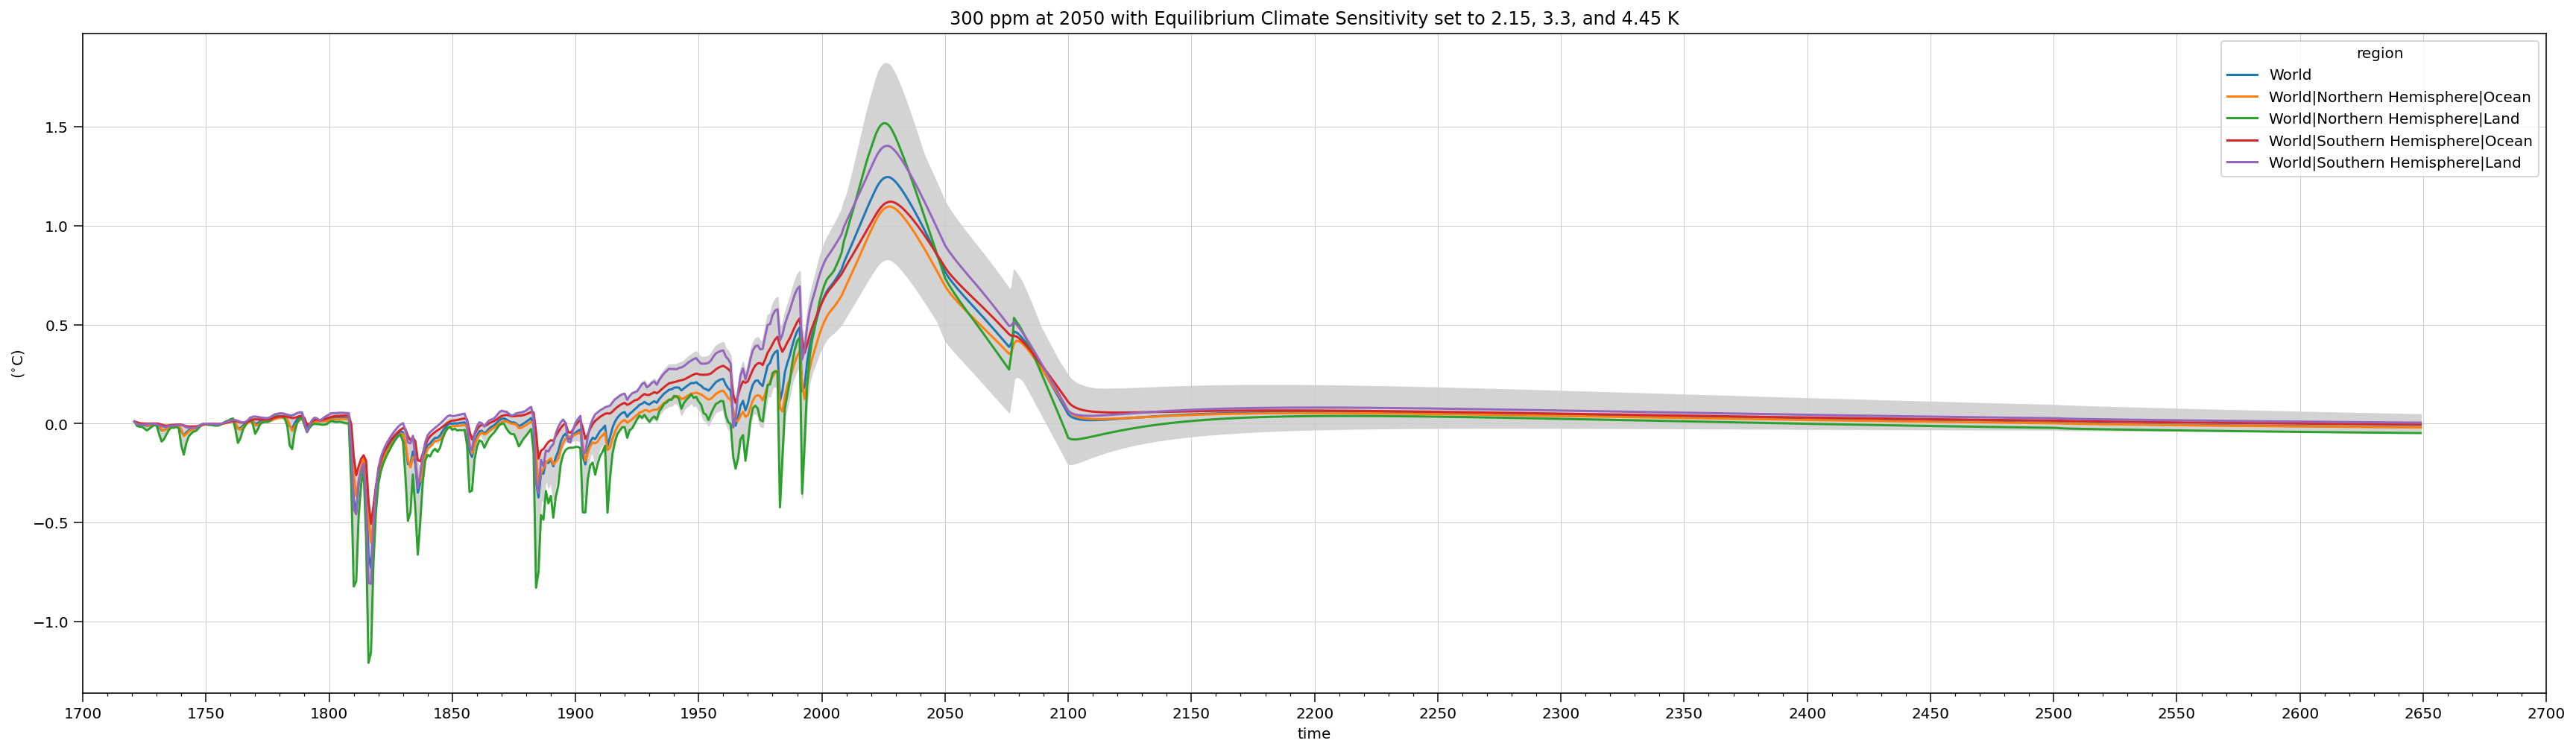

In [65]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(24, 7))
runsdf['default'].filter(**filtering).lineplot( x='time', ax=ax, hue='region')
plt.fill_between(
    runsdf['default'].filter(**filtering, region='World')['time'],
    runsdf['low'].filter(**filtering).timeseries().min().values.squeeze(),
    runsdf['high'].filter(**filtering).timeseries().max().values.squeeze(),
    color='lightgray',
)
utils.var = (f'300 ppm at 2050 with Equilibrium Climate Sensitivity\
 set to {lsitv}, {sitv}, and {hsitv} K')
utils.ylab = '$^{\circ}$C';
utils.plthelpr(ax,plt,profile='full')

-----
-----

## Funding
Anonymous sponsor retired from semiconductor manufacturing, software entrepreneur, @timmo, US economic stimulus. Funding goal has not been met, consider sponsoring: https://github.com/sponsors/safiume.

## References

Open NanoCarbon CDRMEx Project page: https://opennanocarbon.atlassian.net/wiki/spaces/REF/pages/575963137/Method+to+Determine+A+CDR+Target

Pymagicc: A Python wrapper for the simple climate model MAGICC. Journal of Open Source Software, 3(22), 516, R. Gieseke, S. N. Willner and M. Mengel, (2018), https://doi.org/10.21105/joss.00516

MAGICC6, Emulating coupled atmosphere-ocean and carbon cycle models with a simpler model, MAGICC6 – Part 1: Model description and calibration, Meinshausen, M., Raper, S., Wigley, T.,(2011), https://doi.org/10.5194/acp-11-1417-2011

Emulating atmosphere-ocean and carbon cycle models with a simpler model, MAGICC6 – Part 2: Applications, Meinshausen, M., Raper, S., Wigley, T., (2011), https://doi.org/10.5194/acp-11-1457-2011

Scientific assessment of ozone depletion: 2006. Global ozone research and monitoring project Report No. 50. Geneva, Switzerland, World Meteorological Organization: 572, Chapter 8; & Butler et al. 1999, 

A record of atmospheric halocarbons during the twentieth century from polar firn air,James H. Butler, Mark Battle, Michael L. Bender, Stephen A. Montzka, Andrew D. Clarke, Eric S. Saltzman, Cara M. Sucher, Jeffrey P. Severinghaus & James W. Elkins, Nature volume 399, pages 749–755 (1999), https://doi.org/10.1038/21586

Estimating Changes in Global Temperature since the Preindustrial Period, Hawkins, E., Ortega, P.,Suckling, E.,Schurer, A.,Hegerl, G.,Jones, P.,Joshi, M.,Osborn, T.,Masson-Delmotte, V.,Mignot, J.,Thorne P., Oldenborgh, G., (2017), https://doi.org/10.1175/BAMS-D-16-0007.1

Assessment Modeling Consortium & International Institute for Applied Systems Analysis, Huppmann, D., Kriegler, E., Krey, V., Riahi,K., Rogelj, J., Rose,S., Weyant, J., et al., (2018)
https://doi.org/10.22022/SR15/08-2018.15429

IAMC 1.5°C Scenario Explorer and Data hosted by IIASA,https://data.ene.iiasa.ac.at/iamc-1.5c-explorer,  https://data.ene.iiasa.ac.at/iamc-1.5c-explorer/#/license

Scenarios towards limiting global mean temperature increase below 1.5 °C, Rogelj, J., Popp, A., Calvin, K.V. et al., Nature Clim Change 8, 325–332 (2018). https://doi.org/10.1038/s41558-018-0091-3

Global Carbon Budget 2020, Friedlingstein, P. et al., (2020), https://doi.org/10.18160/GCP-2020 

HadCRUT5 data from: An updated assessment of near-surface temperature change from 1850: the HadCRUT5 dataset. Journal of Geophysical Research (Atmospheres), Morice, C., Kennedy, J., Rayner, N., Winn, J., Hogan, E., Killick, R.,  Dunn,R., Osborn,T., Jones,P., Simpson, I., (2020), https://doi.org/10.1029/2019JD032361 https://crudata.uea.ac.uk/cru/data/temperature/

Reduced Complexity Model Intercomparison Project Phase 1: introduction and evaluation of global-mean temperature response, Nicholls, Z., Meinshausen,M., Lewis, J., Gieseke, R., Dommenget, D., Dorheim, K., Fan,C., Fuglestvedt, J., Gasser, T., Golüke, U., Goodwin, P., Hartin, C., Hope, A., Kriegler, E., Leach, N., Marchegiani, D., McBride, L., Quilcaille, Y., Rogelj,J. Salawitch,R., Samset, B., Sandstad, M., Shiklomanov, A., Skeie, R., Smith, C., Smith, S., Tanaka, K., Tsutsui, J., Xie, Z., (2020),https://doi.org/10.5194/gmd-13-5175-2020

Overview of the Coupled Model Intercomparison Project Phase 6 (CMIP6) experimental design and organization, Eyring, V., Bony, S., Meeh, G., Senior, C., Stevens, B., Stouffer, R., Taylor, K., https://doi.org/10.5194/gmd-9-1937-2016
CMIP6 model data is licensed under a Creative Commons Attribution-ShareAlike 4.0 International License (https://creativecommons.org/licenses/). https://pcmdi.llnl.gov/CMIP6/TermsOfUse

The Carbon Dioxide Removal Model Intercomparison Project (CDR-MIP): Rationale and experimental protocol for CMIP6, Keller, D. P., A. Lenton, V. Scott, N. E. Vaughan, N. Bauer, D. Ji, C. D. Jones, B. Kravitz, H. Muri, K. Zickfeld (2018), https://doi.org/10.5194/gmd-11-1133-2018
    